In [1]:
library(tidyverse)
library(magrittr)
library(data.table)
library(ggplot2)
library(ggrepel)
library(reshape)
library(wesanderson)
setwd('/n/hoekstra_lab_tier1/Users/brock/polionotus/pheno/')
source('~/scripts/polionotus_project/R_polionotus_setup.R')

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching p

ERROR: Error in file(file, "rt"): cannot open the connection


# Real data

Categorical data

In [6]:
alb_scores = 
    read.csv('./albifrons_scoring.csv', stringsAsFactors=F) %>% 
    mutate(pop = "ALB")
pol_scores = 
    read.table('./polionotus_skin_scores_062930.txt',fill=T,sep="\t",header=T, stringsAsFactors=F) %>% 
    filter(!is.na(FLANK)) %>% 
    dplyr::select(!c(ANIMALID,X)) %>% 
    dplyr::rename(ANIMALID=MCZ) %>%
    mutate(pop = NA,
          pop = ifelse(ANIMALID %in% c('68174','68180','68184','68186','64653','64654'),'POPOL',pop),
          pop = ifelse(ANIMALID %in% c('69677','69679','69686','69667','69673'),'LO',pop),
          pop = ifelse(ANIMALID %in% c('68144','68146','68147','68149','68152'),'PO',pop))
pol_scores_v2 =
    read.table('./polionotus_skin_scores_102620.txt',fill=T,sep="\t",header=T, stringsAsFactors=F) %>%
    mutate(ANIMALID = gsub("/.*","",ANIMALID) %>% gsub("MCZ","",.))

scores = rbind(alb_scores, pol_scores, pol_scores_v2)

Spectrophotometer data

In [7]:
spec = fread('spec/combined.csv',sep=",") %>% rename(c("folder"="ANIMALID")) %>% mutate(ANIMALID = gsub("MCZ","",ANIMALID))
spec %<>% mutate(filenum = as.numeric(gsub('.*_','',file)))
spec = merge(spec,
              scores %>% dplyr::select(ANIMALID,SPECDORSAL,SPECFLANK,SPECVENTRUM))
spec %<>% mutate(PART = NA,
                 PART = ifelse(grepl('5',SPECDORSAL) & filenum %in% c(1,2,3,4,5),"DORSAL",PART),
                 PART = ifelse(grepl('6',SPECDORSAL) & filenum %in% c(2,3,4,5,6),"DORSAL",PART),
                PART = ifelse(grepl('10',SPECFLANK) & filenum %in% c(6,7,8,9,10),"FLANK",PART),
                PART = ifelse(grepl('11',SPECFLANK) & filenum %in% c(7,8,9,10,11),"FLANK",PART),
                PART = ifelse(grepl('15',SPECVENTRUM) & filenum %in% c(11,12,13,14,15),"VENTRUM",PART),
                PART = ifelse(grepl('16',SPECVENTRUM) & filenum %in% c(12,13,14,15,16),"VENTRUM",PART))
spec %<>% filter(!is.na(PART))
writeable = spec %>% dplyr::select(ANIMALID,Brightness,Hue,Saturation,filenum,PART)
write.table(writeable,'./spectrophotometer_data.txt',sep="\t",quote=F,col.names=T,row.names=F)

Warning message:
“Problem with `mutate()` input `filenum`.
ℹ NAs introduced by coercion
ℹ Input `filenum` is `as.numeric(gsub(".*_", "", file))`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


Write out combined data

In [8]:
summspec = 
    spec %>%
    gather("TRAIT","VALUE",Brightness,Hue,Saturation) %>% 
    dplyr::select(file,ANIMALID,PART,TRAIT,VALUE) %>%
    group_by(ANIMALID,PART,TRAIT) %>%
    mutate(VALUE = as.numeric(VALUE)) %>%
    summarize_at(vars(VALUE), funs(mean(.,na.rm=T),median(.,na.rm=T),sd(.,na.rm=T))) %>%
    dplyr::rename(MEAN=mean, MEDIAN=median,SD=sd) %>%
    ungroup
summspec %<>% 
    gather(stat,val,MEAN:SD) %>% 
    pivot_wider(id_cols = ANIMALID,names_from = c("PART","TRAIT","stat") ,values_from = c("val")) 

Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [9]:
allpheno = left_join(scores, summspec)
#write.table(allpheno,'polionotus_phenotypes.txt',quote=F,col.names=T,row.names=F,sep="\t")

Joining, by = "ANIMALID"



Check image analysis 

In [ ]:
a = fread('./albifrons_image_data.txt') %>% 
    mutate_at(c("LenTailStripe","LenTotalTail"),~ifelse(grepl("cut tail",Notes),NA,.)) %>%
    mutate(TailRatio = LenTailStripe/LenTotalTail) %>%
    mutate(AnimalID = ifelse(grepl("\\(",AnimalID),gsub(".*\\(","",AnimalID),AnimalID),
           AnimalID = ifelse(grepl("\\)",AnimalID),gsub("\\)","",AnimalID),AnimalID))
b = left_join(scores,a %>% dplyr::select(AnimalID,LenTailStripe,LenTotalTail,TailRatio),by=c("ANIMALID"="AnimalID"))
ggplot(b) +
    geom_point(aes(x=TAIL,y=TailRatio)) +
    theme_classic()

Warning message:
“Removed 21 rows containing missing values (position_stack).”

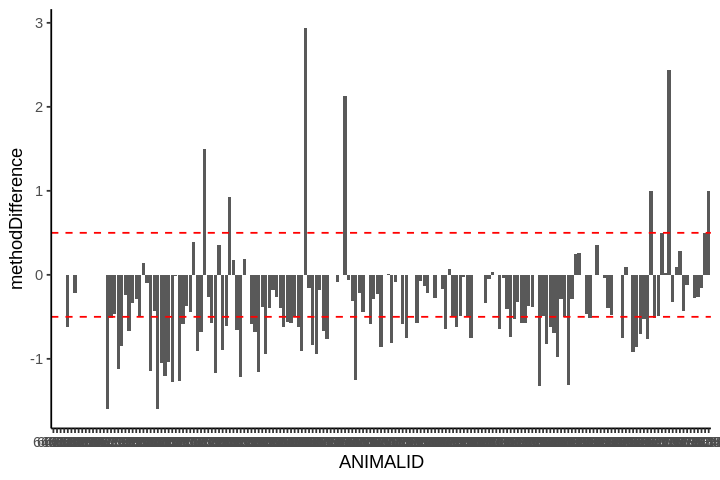

In [127]:
b %<>% 
    dplyr::select(ANIMALID,TAIL,LenTailStripe,LenTotalTail,TailRatio) %>%
    mutate(TailRatioScaled = TailRatio * 4, methodDifference = TailRatioScaled-TAIL)
ggplot(b) +
    geom_bar(aes(x=ANIMALID,y=methodDifference),stat="identity") +
    geom_hline(aes(yintercept = 0.5),lty=2,color="red") +
    geom_hline(aes(yintercept = -0.5),lty=2,color="red") +
    theme_classic()

# PC1 plots

In [10]:
PCs = fread('/n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/Peromyscus_polionotus/results/association/phenoPCA_scores_all_pops.tsv')
alltraits = left_join(allpheno, PCs)

Joining, by = c("ANIMALID", "pop")



In [13]:
alltraits %>% group_by(pop) %>% summarize(count = n())

`summarise()` ungrouping output (override with `.groups` argument)



pop,count
<chr>,<int>
ALB,168
LO,13
PO,5
POPOL,17
SEBM,15


In [20]:
alltraits %>% filter(pop=="ALB") %>% arrange(desc(PC1)) %>% dplyr::select(PC1)

PC1
<dbl>
5.588394
5.116961
4.869497
4.748062
4.597070
4.421352
4.295859
3.764824
3.652098


`summarise()` ungrouping output (override with `.groups` argument)
Warning message:
“Removed 16 rows containing non-finite values (stat_bin).”

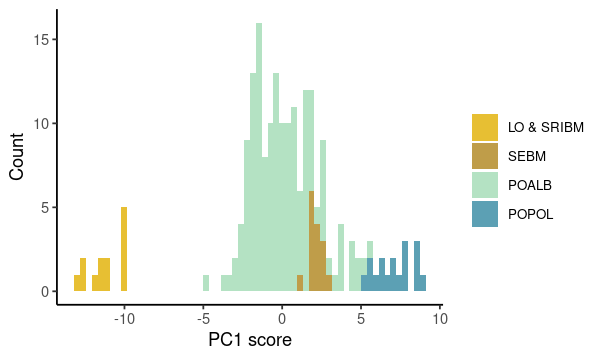

In [18]:
options(repr.plot.height=3,repr.plot.width=5)
# Plot medians as well
meds = alltraits %>% filter(pop != "PO") %>% group_by(pop) %>% summarize(medPC1 = median(PC1,na.rm=T))


p = ggplot(alltraits %>% filter(!pop %in% c("PO"))) +
    geom_histogram(aes(x = PC1, fill = pop), bins = 60,alpha=0.8) +
    scale_fill_manual(name="",
                      values = c(wes_palette("Zissou1")[c(4)],"#AF841C","#a1dab4","#3488A1"),
                      limits = c("LO","SEBM","ALB","POPOL"),
                      labels = c(expression("LO & SRIBM"),
                                 expression("SEBM"),
                                 expression("POALB"),
                                 expression("POPOL"))) +
    ylab('Count') +
    xlab('PC1 score') +
    theme_classic() +
    theme(legend.text.align = 0, legend.position = "right", legend.text = element_text(size=8)) +
    guides(color=FALSE)

p
#ggsave('~/temp/polionotus/Fig2_histogram.svg',p,width=5,height=3)

# Corr matrix

Following Andi's code

In [5]:
library(corrplot)
pheno_master_miss50perc_withPCA = fread('/n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/Peromyscus_polionotus/results/association/pheno_master_miss50perc_withPCA.tsv')
head(pheno_master_miss50perc_withPCA)

corrplot 0.84 loaded


ANIMALID,DATE,MEASURER,DORSAL,FLANK,VENTRUM,TAIL,RUMPSHAPE,RUMPSHADOW,ANKLESHADOW,⋯,FLANK_Hue_SD,FLANK_Saturation_SD,VENTRUM_Brightness_SD,VENTRUM_Hue_SD,VENTRUM_Saturation_SD,PC1,PC2,PC3,PC4,PC5
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
VSD142,03.16.20,Brock_Sade,2,2,1.0,2,3,0.0,1,⋯,0.7795865,0.013547966,15.106604,2.233756,0.003659004,-0.6202107,1.0727269,3.0061566,1.6010145,-1.737076
VSD143,03.16.20,Brock_Sade,2,2,1.0,1,2,1.0,1,⋯,0.5936450,0.006023102,19.685199,2.313882,0.002500938,-0.7697713,2.2910125,-1.7207999,0.1683995,-1.103464
VSD195,03.16.20,Brock_Sade,2,2,1.0,1,2,1.0,1,⋯,0.4866924,0.005329747,39.541213,1.707222,0.003721026,-0.4760445,0.1590868,-1.3096745,-2.3313230,1.817745
VSD196,03.16.20,Brock_Sade,2,2,1.5,2,3,1.0,1,⋯,0.4782957,0.009602331,19.016059,1.684956,0.004493429,0.5332623,-0.2442339,-0.7966364,0.9678556,1.959624
VSD197,03.16.20,Brock_Sade,2,2,1.0,2,3,0.5,1,⋯,0.7575597,0.009409101,5.691249,1.228939,0.004379529,1.3772941,0.6680722,-2.2703870,1.3060946,-2.360214
VSD198,03.16.20,Brock_Sade,2,2,0.5,3,3,1.0,1,⋯,0.6059991,0.010930476,21.464760,1.648137,0.001971648,1.7823115,-1.4919914,0.2971955,0.3968029,1.559225


Warning message:
“Removed 268 rows containing missing values (geom_text).”Warning message:
“Removed 268 rows containing missing values (geom_text).”

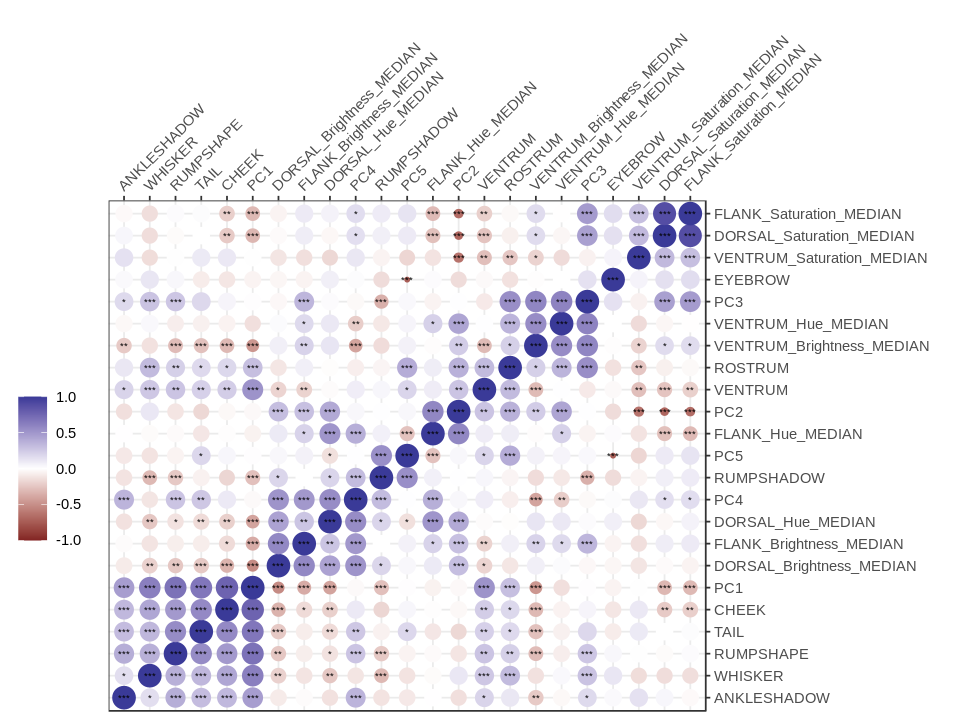

In [236]:
## INPUT DATA ##
cor_mat <- pheno_master_miss50perc_withPCA %>% 
    select(-c(ANIMALID,MEASURER,DATE,NOTES,pop,starts_with("SPEC"))) %>%
    select(-c(DORSAL,FLANK,EARBASE,BETWEENEYES,contains("_MEAN"),contains("_SD"))) %>%
    cor(., method="pearson", use="complete.obs")
corr_mat_sig <- pheno_master_miss50perc_withPCA %>% 
    select(-c(ANIMALID,MEASURER,DATE,NOTES,pop,starts_with("SPEC"))) %>%
    select(-c(DORSAL,FLANK,EARBASE,BETWEENEYES,contains("_MEAN"),contains("_SD"))) %>%
    cor.mtest()


## CLUSTERING STEP ##
reorder_cormat <- function(cormat){
# Use correlation between variables as distance
dd <- as.dist((1-cormat)/2)
hc <- hclust(dd, method = "ward.D")
cormat <-cormat[hc$order, hc$order]
}
# Use cor_mat that Andi provided
temp = reorder_cormat(cor_mat)
fct_order = row.names(temp)

## RESTRUCTURING CORRELATION MATRIX ## 
cor_mat_plottable =
    temp %>%
    data.frame(row.names = rownames(.)) %>%
    rownames_to_column(var = "TRAIT1") %>%
    gather(key = "TRAIT2", value = "r", -1)

cor_mat_plottable$TRAIT1 = factor(cor_mat_plottable$TRAIT1, levels = fct_order)
cor_mat_plottable$TRAIT2 = factor(cor_mat_plottable$TRAIT2, levels = fct_order)

## RESTRUCTURING SIGNIFICANCE MATRIX ##
sig_mat = corr_mat_sig$p
colnames(sig_mat) = colnames(cor_mat)
rownames(sig_mat) = rownames(cor_mat)
sig_mat_plottable = 
    sig_mat %>%
    data.frame(row.names = rownames(.)) %>%
    rownames_to_column(var = "sigTRAIT1") %>%
    gather(key = "sigTRAIT2", value = "p", -1) %>%
    mutate(annotation = NA,
           annotation = ifelse(p < 0.05, "*", annotation),
           annotation = ifelse(p < 0.01, "**", annotation),
           annotation = ifelse(p < 0.001, "***", annotation))
sig_mat_plottable$sigTRAIT1 = factor(sig_mat_plottable$sigTRAIT1, levels = fct_order)
sig_mat_plottable$sigTRAIT2 = factor(sig_mat_plottable$sigTRAIT2, levels = fct_order)
    

## PLOT ##
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(cor_mat_plottable) +
    geom_point(aes(x=TRAIT1,y=TRAIT2,color=r, size = r)) +
    scale_color_gradient2(name="",limits = c(-1,1)) +
    scale_size(guide="none") +
    geom_text(data = sig_mat_plottable,aes(x=sigTRAIT1,y=sigTRAIT2,label = annotation),size=2) +
    theme_bw() +
    ylab("") +
    xlab("") +
    theme(axis.text.x = element_text(angle=45,hjust=0), legend.position = "left") +
    scale_y_discrete(position="right") +
    scale_x_discrete(position="top")

ggsave('~/temp/polionotus/correlation_matrix.svg',width=8,height=6)

## Without PCs and saturation

In [2]:
translation = fread('albifrons_trait_translation.csv')
cor_mat_plottable =
    temp %>% 
    data.frame(row.names = rownames(.)) %>%
    rownames_to_column(var = "TRAIT1") %>%
    gather(key = "TRAIT2", value = "r", -1) #
#left_join(left_join(cor_mat_plottable,translation, by = c('TRAIT1'='Old')),translation,by=c("TRAIT2"="Old")) %>% 
#mutate(sTRAIT1=New.x,sTRAIT2=New.y)

ERROR: Error in eval(lhs, parent, parent): object 'temp' not found


In [32]:
cor_mat_plottable =
    temp %>% 
    data.frame(row.names = rownames(.)) %>%
    rownames_to_column(var = "TRAIT1") %>%
    gather(key = "TRAIT2", value = "r", -1) #
cor_mat_plottable = left_join(left_join(cor_mat_plottable,translation, by = c('TRAIT1'='Old')),translation,by=c("TRAIT2"="Old")) %>% mutate(cTRAIT1=New.x,cTRAIT2=New.y)
cor_mat_plottable$TRAIT1 = factor(cor_mat_plottable$TRAIT1, levels = fct_order)
cor_mat_plottable$cTRAIT1 = reorder(cor_mat_plottable$cTRAIT1, cor_mat_plottable$TRAIT1)
#cor_mat_plottable$TRAIT2 = factor(cor_mat_plottable$TRAIT2, levels = fct_order)
#cor_mat_plottable$cTRAIT2 = factor(cor_mat_plottable$cTRAIT2, cor_mat_plottable$TRAIT2)

Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”Warning message in mean.default(X[[i]], 

In [42]:
cor_mat <- pheno_master_miss50perc_withPCA %>% dplyr::select(!matches("PC|Saturation")) %>% 
    select(-c(ANIMALID,MEASURER,DATE,NOTES,pop,starts_with("SPEC"))) %>%
    select(-c(DORSAL,FLANK,EARBASE,BETWEENEYES,contains("_MEAN"),contains("_SD"))) %>%
    rename_at(vars(translation$Old), function(x) translation$New) %>%
    cor(., method="pearson", use="complete.obs")
cor_mat
fct_order
        
cor_mat_plottable

,Ventrum,Tail stripe,Rump shape,Rump shadow,Ankle shadow,Eyebrow,Cheek,Whisker,Rostrum,Dorsal (Brightness),Dorsal (Hue),Flank (Brightness),Flank (Hue),Ventrum (Brightness),Ventrum (Hue)
Ventrum,1.000000000,0.21903332,0.27778661,0.043746776,0.200604835,-0.026003464,0.234265784,0.26081631,0.32219296,-0.18854196,-0.01598488,-0.195471769,0.086106051,-0.301793101,0.003258867
Tail stripe,0.219033322,1.00000000,0.55566859,-0.062472921,0.314274324,-0.084204600,0.568419590,0.33913763,0.17637420,-0.23891804,-0.15911701,-0.080847982,-0.107927560,-0.274588242,-0.066668808
Rump shape,0.277786609,0.55566859,1.00000000,-0.237702754,0.386747809,0.038232084,0.490540396,0.37568873,0.22053077,-0.24770343,-0.12767388,-0.076151709,-0.021780891,-0.296480040,-0.078025932
Rump shadow,0.043746776,-0.06247292,-0.23770275,1.000000000,-0.123727347,-0.152644995,-0.181654299,-0.31319262,-0.04635935,0.19319952,0.19520337,0.001629206,0.069377423,-0.151782182,-0.101417701
Ankle shadow,0.200604835,0.31427432,0.38674781,-0.123727347,1.000000000,0.026285580,0.333307343,0.15526463,0.11303866,-0.08759778,-0.13255702,-0.017489800,0.002545573,-0.235412672,-0.030888228
Eyebrow,-0.026003464,-0.08420460,0.03823208,-0.152644995,0.026285580,1.000000000,-0.110081028,0.11490286,-0.13095064,-0.04011666,0.07433746,-0.052852935,0.016778733,-0.008472658,-0.001316213
Cheek,0.234265784,0.56841959,0.49054040,-0.181654299,0.333307343,-0.110081028,1.000000000,0.42301427,0.18310092,-0.34065891,-0.20873171,-0.158299739,-0.009202807,-0.310538631,-0.055217480
Whisker,0.260816307,0.33913763,0.37568873,-0.313192623,0.155264632,0.114902863,0.423014270,1.00000000,0.32307160,-0.20125456,-0.24675098,-0.117296350,-0.018955925,-0.132011977,0.033333608
Rostrum,0.322192963,0.17637420,0.22053077,-0.046359351,0.113038659,-0.130950641,0.183100925,0.32307160,1.00000000,-0.10991884,-0.01087247,0.074037621,0.084818414,0.222010128,0.355356246
Dorsal (Brightness),-0.188541963,-0.23891804,-0.24770343,0.193199516,-0.087597777,-0.040116660,-0.340658913,-0.20125456,-0.10991884,1.00000000,0.44313473,0.576185473,0.098870515,0.075065707,0.019266700


[1] "Ventrum"              "Whisker"              "Rostrum"             
 [4] "Ankle shadow"         "Rump shape"           "Tail stripe"         
 [7] "Cheek"                "Dorsal (Brightness)"  "Flank (Brightness)"  
[10] "Rump shadow"          "Dorsal (Hue)"         "Flank (Hue)"         
[13] "Eyebrow"              "Ventrum (Brightness)" "Ventrum (Hue)"

TRAIT1,TRAIT2,r
<fct>,<fct>,<dbl>
Ventrum,Ventrum,1.000000000
Whisker,Ventrum,0.260816307
Rostrum,Ventrum,0.322192963
Ankle shadow,Ventrum,0.200604835
Rump shape,Ventrum,0.277786609
Tail stripe,Ventrum,0.219033322
Cheek,Ventrum,0.234265784
Dorsal (Brightness),Ventrum,-0.188541963
Flank (Brightness),Ventrum,-0.195471769


In [47]:
?rownames_to_column

In [55]:
proper_colnames = colnames(temp) 
temp %>% 
    data.frame(row.names = rownames(.)) %>%
    rownames_to_column(var = "TRAIT1") %>%
    set_colnames(c("TRAIT1",proper_colnames)) %>%
    gather(key = "TRAIT2", value = "r", -1) 

TRAIT1,TRAIT2,r
<chr>,<chr>,<dbl>
Ventrum,Ventrum,1.000000000
Whisker,Ventrum,0.260816307
Rostrum,Ventrum,0.322192963
Ankle shadow,Ventrum,0.200604835
Rump shape,Ventrum,0.277786609
Tail stripe,Ventrum,0.219033322
Cheek,Ventrum,0.234265784
Dorsal (Brightness),Ventrum,-0.188541963
Flank (Brightness),Ventrum,-0.195471769


Warning message:
“Removed 108 rows containing missing values (geom_text).”Warning message:
“Removed 108 rows containing missing values (geom_text).”

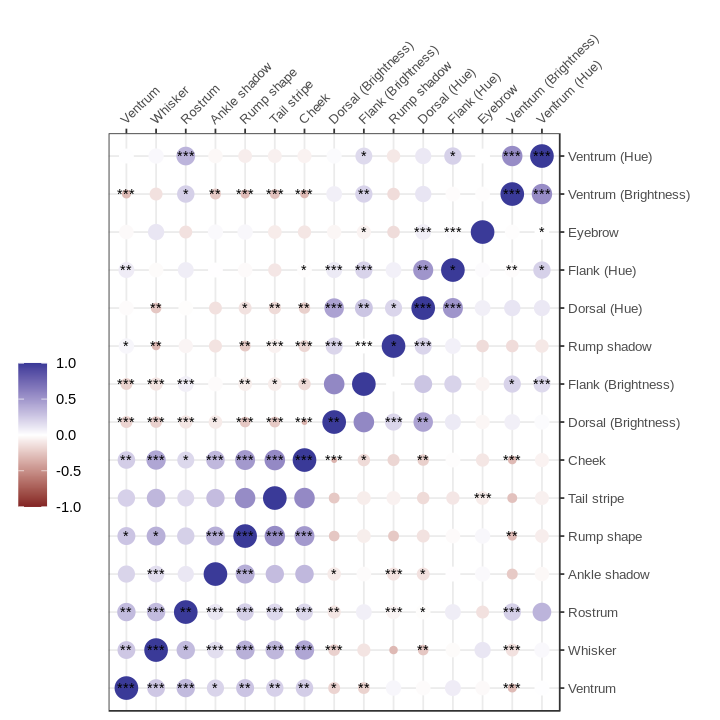

In [59]:
## INPUT DATA ##
cor_mat <- pheno_master_miss50perc_withPCA %>% dplyr::select(!matches("PC|Saturation")) %>% 
    select(-c(ANIMALID,MEASURER,DATE,NOTES,pop,starts_with("SPEC"))) %>%
    select(-c(DORSAL,FLANK,EARBASE,BETWEENEYES,contains("_MEAN"),contains("_SD"))) %>%
    rename_at(vars(translation$Old), function(x) translation$New) %>%
    cor(., method="pearson", use="complete.obs")
corr_mat_sig <- pheno_master_miss50perc_withPCA %>% dplyr::select(!matches("PC|Saturation")) %>%
    select(-c(ANIMALID,MEASURER,DATE,NOTES,pop,starts_with("SPEC"))) %>%
    select(-c(DORSAL,FLANK,EARBASE,BETWEENEYES,contains("_MEAN"),contains("_SD"))) %>%
    rename_at(vars(translation$Old), function(x) translation$New) %>%
    cor.mtest()

translation = fread('albifrons_trait_translation.csv')



## CLUSTERING STEP ##
reorder_cormat <- function(cormat){
# Use correlation between variables as distance
dd <- as.dist((1-cormat)/2)
hc <- hclust(dd, method = "ward.D")
cormat <-cormat[hc$order, hc$order]
}
# Use cor_mat that Andi provided
temp = reorder_cormat(cor_mat)
fct_order = row.names(temp)


## RESTRUCTURING CORRELATION MATRIX ## 
proper_colnames = colnames(temp)
cor_mat_plottable =
    temp %>% 
    data.frame(row.names = rownames(.)) %>%
    rownames_to_column(var = "TRAIT1") %>%
    set_colnames(c("TRAIT1",proper_colnames)) %>%
    gather(key = "TRAIT2", value = "r", -1) 

cor_mat_plottable$TRAIT1 = factor(cor_mat_plottable$TRAIT1, levels = fct_order)
cor_mat_plottable$TRAIT2 = factor(cor_mat_plottable$TRAIT2, levels = fct_order)


## RESTRUCTURING SIGNIFICANCE MATRIX ##
sig_mat = corr_mat_sig$p
colnames(sig_mat) = colnames(cor_mat)
rownames(sig_mat) = rownames(cor_mat)
sig_mat_plottable = 
    sig_mat %>%
    data.frame(row.names = rownames(.)) %>%
    rownames_to_column(var = "sigTRAIT1") %>%
    set_colnames(c("sigTRAIT1",proper_colnames)) %>%
    gather(key = "sigTRAIT2", value = "p", -1) %>%
    mutate(annotation = NA,
           annotation = ifelse(p < 0.05, "*", annotation),
           annotation = ifelse(p < 0.01, "**", annotation),
           annotation = ifelse(p < 0.001, "***", annotation)) %>%
    mutate(sigTRAIT1 = gsub("_MEDIAN","",sigTRAIT1),sigTRAIT2 = gsub("_MEDIAN","",sigTRAIT2)) 
sig_mat_plottable$sigTRAIT1 = factor(sig_mat_plottable$sigTRAIT1, levels = fct_order)
sig_mat_plottable$sigTRAIT2 = factor(sig_mat_plottable$sigTRAIT2, levels = fct_order)
    

## PLOT ##
options(repr.plot.height = 6, repr.plot.width = 6)
ggplot(cor_mat_plottable) +
    geom_point(aes(x=TRAIT1,y=TRAIT2,color=r, size = r)) +
    scale_color_gradient2(name="",limits = c(-1,1)) +
    scale_size(guide="none") +
    geom_text(data = sig_mat_plottable,aes(x=sigTRAIT1,y=sigTRAIT2,label = annotation),size=3) +
    theme_bw() +
    ylab("") +
    xlab("") +
    theme(axis.text =  element_text(size=8),axis.text.x = element_text(angle=45,hjust=0,vjust=1), legend.position = "left") +
    scale_y_discrete(position="right") +
    scale_x_discrete(position="top")

ggsave('~/temp/polionotus/correlation_matrix_minimal.svg',width=7,height=5)

In [40]:
cor_mat_plottable

TRAIT1,TRAIT2,r
<fct>,<fct>,<dbl>
Ventrum,Ventrum,1.000000000
Whisker,Ventrum,0.260816307
Rostrum,Ventrum,0.322192963
Ankle shadow,Ventrum,0.200604835
Rump shape,Ventrum,0.277786609
Tail stripe,Ventrum,0.219033322
Cheek,Ventrum,0.234265784
Dorsal (Brightness),Ventrum,-0.188541963
Flank (Brightness),Ventrum,-0.195471769


## PC1 loadings

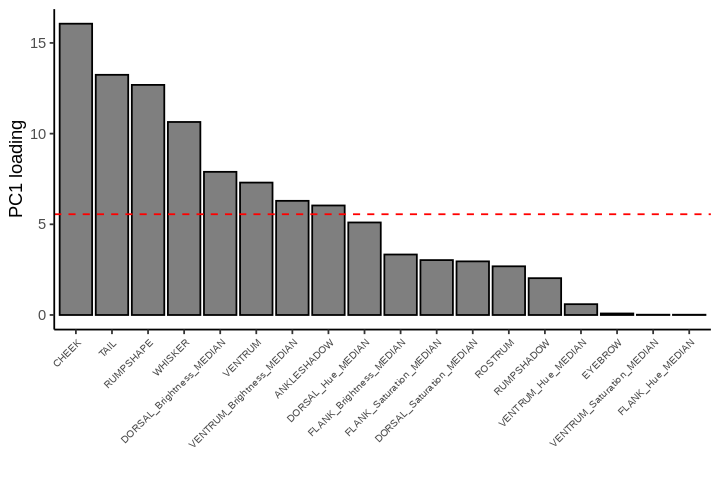

In [71]:
lds = fread('loadings.tsv') 
lds$Trait <- factor(lds$Trait, levels = lds$Trait[order(-lds$Dim.1)])

options(repr.plot.height=4,repr.plot.width=6)
ggplot(lds %>% dplyr::select(!contains("Saturation"))) +
    geom_bar(aes(x=Trait,y=Dim.1),stat="identity", color = "black", fill="black", alpha=0.5) +
    geom_hline(aes(yintercept = (1/nrow(lds))*100),lty=2,color="red") +
    theme_classic() +
    theme(axis.text.x = element_text(angle=45,hjust=1, vjust= 1, size = 6)) +
    ylab("PC1 loading") +
    xlab("")
ggsave('~/temp/polionotus/loadings.svg',width=6,height=5)

# Explore spectrophotometer data

Are there any bizarre outliers?

In [10]:
summspec = 
    spec %>% 
    gather("TRAIT","VALUE",Brightness,Hue,Saturation) %>% 
    dplyr::select(file,ANIMALID,PART,TRAIT,VALUE) %>%
    group_by(ANIMALID,PART,TRAIT) %>%
    summarize_at(vars(VALUE), funs(mean,median,sd)) %>%
    ungroup
head(summspec)
write.table(summspec,"spectrophotometer_data_summarized.txt",sep="\t",col.names=T,row.names=F,quote=F)

ANIMALID,PART,TRAIT,mean,median,sd
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
VSD142,DORSAL,Brightness,51.2002954,49.4727918,4.32464500
VSD142,DORSAL,Hue,41.3683435,41.5126089,0.46858195
VSD142,DORSAL,Saturation,0.2412223,0.2441390,0.01083063
VSD142,FLANK,Brightness,83.5029009,84.0021180,1.59183967
VSD142,FLANK,Hue,44.9168712,45.0654120,0.77958648
VSD142,FLANK,Saturation,0.1979352,0.2022498,0.01354797


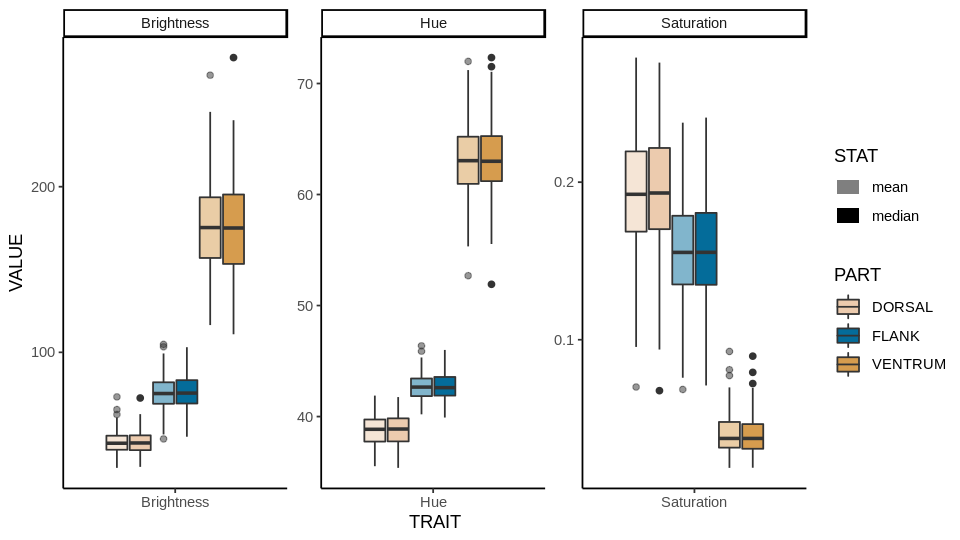

In [26]:
plottable = summspec %>% gather("STAT","VALUE",mean,median,sd)
options(repr.plot.width=8,repr.plot.height=4.5)
ggplot(plottable %>% filter(STAT %in% c("mean","median"))) +
    geom_boxplot(aes(x=TRAIT,fill=PART,alpha=STAT,y=VALUE)) +
    facet_wrap(~TRAIT, scales="free") + 
    scale_fill_manual(values = wes_palette("Darjeeling2")) + 
    scale_alpha_manual(values = c(0.5,1)) +
    guides(alpha=guide_legend(override.aes=list(fill=hcl(c(15,195),100,0,alpha=c(0.5,1)),colour=NA))) +
    theme_classic()

Look at correlation

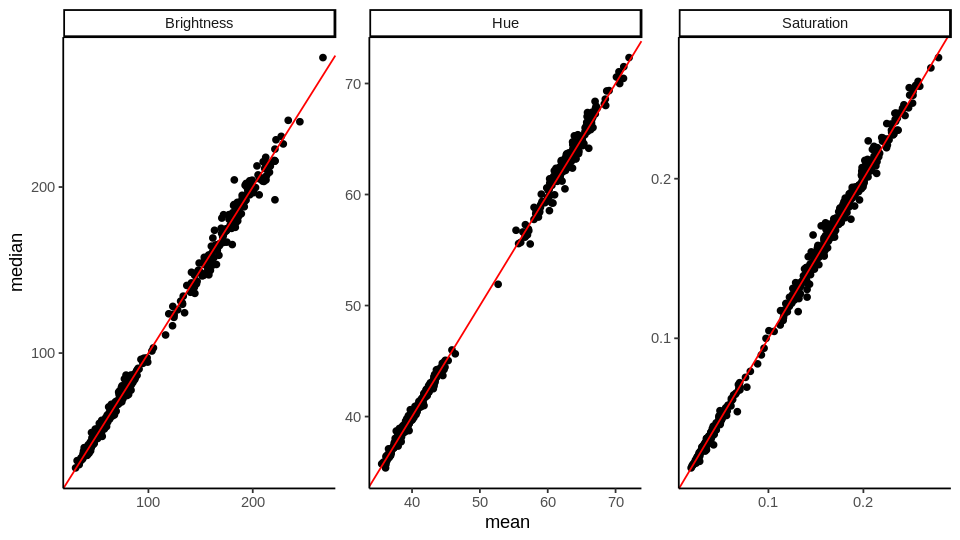

In [32]:
ggplot(summspec) +
    geom_point(aes(x=mean,y=median)) +
    facet_wrap(~TRAIT,scales="free")  +
    geom_abline(slope=1,color = "red") +
    theme_classic()

In [28]:
head(summspec)

ANIMALID,PART,TRAIT,mean,median,sd
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
VSD142,DORSAL,Brightness,51.2002954,49.4727918,4.32464500
VSD142,DORSAL,Hue,41.3683435,41.5126089,0.46858195
VSD142,DORSAL,Saturation,0.2412223,0.2441390,0.01083063
VSD142,FLANK,Brightness,83.5029009,84.0021180,1.59183967
VSD142,FLANK,Hue,44.9168712,45.0654120,0.77958648
VSD142,FLANK,Saturation,0.1979352,0.2022498,0.01354797


In [35]:
test = c(0.02,0.02,0.02,0.04)
p.adjust(test,method="fdr",3)

ERROR: Error in p.adjust(test, method = "fdr", 3): n >= lp is not TRUE


# Comparison of categorical test set

In [2]:
brock = read.csv("./albifrons_test_scoring.csv")
sade = read.csv("./Sade_test_scoring.csv")
comb = rbind(brock %>% dplyr::select(-DATE),sade %>% dplyr::select(-DATE))
comb

ANIMALID,MEASURER,DORSAL,FLANK,VENTRUM,TAIL,RUMPSHAPE,RUMPSHADOW,ANKLESHADOW,EARBASE,EYEBROW,CHEEK,WHISKER,BETWEENEYES,ROSTRUM
<fct>,<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
VSD245,Brock,2,2,1,2.0,4.0,1.0,1.0,NA,1.0,0.5,1,2,1.0
VSD246,Brock,2,2,1,3.0,4.0,1.5,2.0,2.0,1.0,2.0,2,2,2.0
VSD247,Brock,2,2,1,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1,2,NA
VSD248,Brock,2,2,0,1.0,2.0,0.5,0.5,1.0,1.0,1.0,1,2,1.0
VSD249,Brock,2,2,1,2.0,3.0,1.0,2.0,2.0,1.5,1.0,2,2,1.0
VSD250,Brock,2,2,0,2.0,3.0,1.0,1.0,2.0,1.0,2.0,2,2,2.0
VSD251,Brock,2,2,1,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1,2,1.0
VSD252,Brock,2,2,1,2.5,3.0,1.0,1.0,2.0,2.0,1.0,1,2,2.0
VSD253,Brock,2,2,1,3.0,2.5,1.0,1.0,2.0,1.0,1.0,2,2,2.0


ANIMALID,TRAIT,Brock,SSM
<fct>,<chr>,<dbl>,<dbl>
VSD245,ANKLESHADOW,1.0,1
VSD245,BETWEENEYES,2.0,2
VSD245,CHEEK,0.5,1
VSD245,DORSAL,2.0,2
VSD245,EARBASE,NA,1
VSD245,EYEBROW,1.0,1


Warning message:
“Removed 9 rows containing non-finite values (stat_sum).”

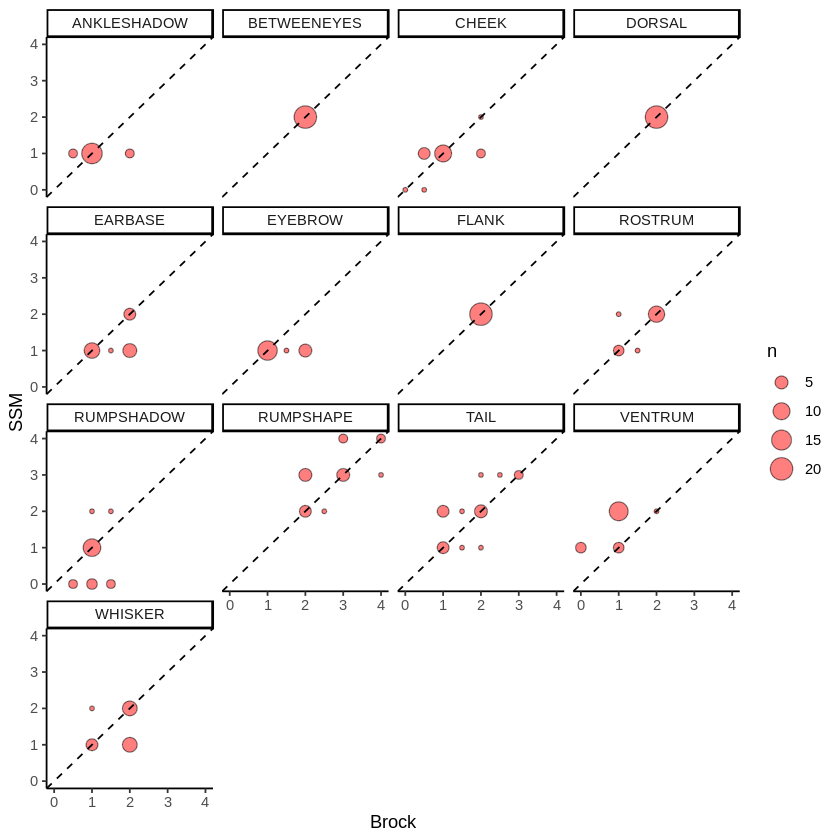

In [3]:
long = comb %>% gather("TRAIT","SCORE",-c(1,2))
scatter = long %>% spread(MEASURER,SCORE)
head(scatter)
ggplot(scatter) +
    geom_count(aes(x=Brock,y=SSM),pch=21,color="black",fill="red",alpha=0.5) +
    geom_abline(aes(intercept=0,slope=1),lty=2) +
    facet_wrap(~TRAIT) +
    theme_classic()

In [15]:
scatter %>% filter(TRAIT=="ANKLESHADOW") %>% filter(Brock != SSM)
scatter %>% filter(TRAIT=="ANKLESHADOW") %>% filter(Brock == SSM)

ANIMALID,TRAIT,Brock,SSM
<fct>,<chr>,<dbl>,<dbl>
VSD246,ANKLESHADOW,2.0,1
VSD248,ANKLESHADOW,0.5,1
VSD249,ANKLESHADOW,2.0,1
VSD265,ANKLESHADOW,0.5,1


ANIMALID,TRAIT,Brock,SSM
<fct>,<chr>,<dbl>,<dbl>
VSD245,ANKLESHADOW,1,1
VSD247,ANKLESHADOW,1,1
VSD250,ANKLESHADOW,1,1
VSD251,ANKLESHADOW,1,1
VSD252,ANKLESHADOW,1,1
VSD253,ANKLESHADOW,1,1
VSD254,ANKLESHADOW,1,1
VSD266,ANKLESHADOW,1,1
VSD267,ANKLESHADOW,1,1


# Spectrophotometer

Annotate vars data w/ parts info

In [12]:
## Vars
vars = fread("test_run.var")

## Image_num. to parts
parts = fread('var_translation.txt',colClasses = "character")

## Annotate and select vars of interest
vars %<>% mutate(Num = gsub(".*_","",File),
               Person = gsub("_.*","",Folder),
               Day = gsub("^[^_]+_","",Folder) %>% gsub("_.*","",.),
                Specimen = gsub("_.*","",File),
                Specimen = ifelse(grepl("MCZ2",Specimen),gsub("MCZ2","MCZ",Specimen),Specimen))
vars = left_join(vars,parts)

## Grab only the interesting variables
vars %<>% 
    dplyr::select(Specimen,Part,Person,Day,B1,H4a,S5a) %>%
    # Following Emily Hager's instructions
    mutate(H4a = H4a * (180/pi),
           S5a = S5a/B1)

Joining, by = "Num"


# Analysis

In [35]:
summvars = 
    vars %>% filter(!is.na(Part)) %>% 
    dplyr::group_by(Specimen,Part,Person,Day) %>%
    summarize_at(vars(-group_cols()), median)

summvars %<>% ungroup %<>% gather("SpecVar","Value",-Specimen,-Part,-Person,-Day)
head(summvars)

Specimen,Part,Person,Day,SpecVar,Value
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
MCZ68232,Cheek,brock,d1,B1,132.56762
MCZ68232,Cheek,brock,d2,B1,117.82260
MCZ68232,Cheek,sade,d1,B1,152.14073
MCZ68232,Cheek,sade,d2,B1,164.80558
MCZ68232,Dorsal,brock,d1,B1,40.87826
MCZ68232,Dorsal,brock,d2,B1,38.48722


## Intra-observer

In [33]:
plottable = summvars %>% filter(Person=="sade",Part==part) %>% spread(Day,Value) %>% filter(!is.na(Part))
plottable

Specimen,Part,Person,SpecVar
<chr>,<chr>,<chr>,<chr>


In [43]:
pdf('~/temp/brock_d1_d2.pdf',width = 9,height=3)
options(repr.plot.height = 3, repr.plot.width=9)
plots = 
    for (part in unique(summvars$Part)){
        plottable = summvars %>% filter(Person=="brock",Part==part) %>% spread(Day,Value)
        p = ggplot(plottable) +
            geom_point(aes(x=d1,y=d2),alpha=0.5) +
            geom_label_repel(aes(x=d1,y=d2,label=Specimen),alpha=0.5) +
            geom_abline(slope=1) + 
            facet_wrap(~SpecVar,scales="free") +
            theme_classic() +
            ggtitle(part)
        print(p)
    }
dev.off()

png 
  2

## Inter-observer 

In [53]:
pdf('~/temp/inter_d1.pdf',width = 9,height=3)
options(repr.plot.height = 3, repr.plot.width=9)
plots = 
    for (part in unique(summvars$Part)){
        plottable = summvars %>% filter(Day=="d1",Part == part) %>% spread(Person,Value)
        p = ggplot(plottable) +
            geom_point(aes(x=brock,y=sade),alpha=0.5) +
            geom_label_repel(aes(x=brock,y=sade,label=Specimen),alpha=0.5) +
            geom_abline(slope=1) + 
            facet_wrap(~SpecVar,scales="free") +
            theme_classic() +
            ggtitle(part)
        print(p)
    }
dev.off()

png 
  2